# SEAB Airline Tweets Sentiment Analysis

Credit: [Twitter Sentiment Analysis with BERT vs RoBERTa](https://www.kaggle.com/code/ludovicocuoghi/twitter-sentiment-analysis-with-bert-vs-roberta#Twitter-Sentiment-Analysis-with-BERT-and-roBERTa-transformers)

I referenced this Kaggle notebook with my own modifications, especially in the preprocessing step. This project by LUDOVICO CUOGHI is applicable to this use case as he also used a Tweet dataset.

## Install packages

In [341]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\65965\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


We will be using RoBERTa, which is an improved version of BERT, by introducing modifications to the training process that aim to address certain limitations of BERT. The model is trained on financial news and can be classified into "Positive", "Negative" and "Neutral". Not all LLMs are trained with three types of sentiments but DistilRoBERTa is one of them.

In [383]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

#transformers
# Load model directly
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#set seed for reproducibility
seed=42

## Load data

In [343]:
df = pd.read_csv('airline_tweets.csv')

In [344]:
df.head()

,tweet_id,airline_sentiment,airline,text
0,A0000001,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,A0000002,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,A0000003,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,A0000004,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,A0000005,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14638 entries, 0 to 14637
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet_id           14638 non-null  object
 1   airline_sentiment  14638 non-null  object
 2   airline            14638 non-null  object
 3   text               14638 non-null  object
dtypes: object(4)
memory usage: 457.6+ KB


### Drop duplicate tweets

In [346]:
df.drop_duplicates(subset='text',inplace=True)

## Clean data

Instead of purely removing emojis as a whole, I decided to keep them as they help in sentiment analysis, especially in the context of tweets. For example, if we removed the emojis for tweets like, "I ❤️ flying @VirginAmerica. ☺️👍", the resulting tweet becomes, "I flying @VirginAmerica". The former tweet has a positive sentiment while the latter tweet has a neutral sentiment.

In [347]:
#Add a space after every emoji
def add_space_after_emoji(text):
    result = ''
    for char in text:
        result += char
        if emoji.demojize(char) != char:  # Check if the character is an emoji
            result += ' '  # Add a space after the emoji
    return result

#Clean emojis from text
def convert_emojis(text):
    return emoji.demojize(text)

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [348]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(convert_emojis(add_space_after_emoji(t)))))))

### Create new column for the cleaned text

In [349]:
df['text_clean'] = texts_new

In [350]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [351]:
df['text_len'] = text_len

In [352]:
df['text_clean'] = texts_new

### Drop tweets with less than 5 words

In [353]:
print(f" DF SHAPE: {df.shape}")
df = df[df['text_len'] > 4]
print(f" DF SHAPE: {df.shape}")

 DF SHAPE: (14425, 6)
 DF SHAPE: (13598, 6)


## Sentiment column analysis

In [354]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    8895
neutral     2728
positive    1975
Name: count, dtype: int64

### Map sentiments to integer

In [355]:
df['airline_sentiment'] = df['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

## Data preparation for model training

### Train-test split

In [356]:
X = df['text_clean']
y = df['airline_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Handle imbalanced data

In [357]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['airline_sentiment']).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'airline_sentiment'])

In [358]:
train_os['airline_sentiment'].value_counts()

airline_sentiment
 1    8895
 0    8895
-1    8895
Name: count, dtype: int64

In [359]:
X = train_os['text_clean'].values
y = train_os['airline_sentiment'].values

### Extract validation set from train set

In [360]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y)

### One-hot encoding

In [361]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [362]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [363]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 24016
VALIDATION DATA: 2669
TESTING DATA: 2720


## RoBERTa sentiment analysis

In [364]:
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

### Check length of the longest tokenized sentence

In [365]:
token_lens = []

for txt in X_train:
    tokens = roberta_tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

92

In [366]:
MAX_LEN=128

### Define tokenization function with MAX_LEN variable

In [367]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = roberta_tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

### Tokenize inputs

In [368]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
X_test = X_test.tolist()
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

### Define model function with MAX_LEN variable

In [369]:
def create_model(roberta_model, max_len=MAX_LEN):
    
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    print(input_ids)
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    print(attention_masks)
    output = roberta_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [370]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.int32, name='input_21'), name='input_21', description="created by layer 'input_21'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.int32, name='input_22'), name='input_22', description="created by layer 'input_22'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_21[0][0]',            


### Train the RoBERTa model

In [371]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

Epoch 1/4
801/801 [==============================] - 8698s 11s/step - loss: 0.4676 - categorical_accuracy: 0.8165 - val_loss: 0.3096 - val_categorical_accuracy: 0.8932
Epoch 2/4
801/801 [==============================] - 8923s 11s/step - loss: 0.2437 - categorical_accuracy: 0.9149 - val_loss: 0.2129 - val_categorical_accuracy: 0.9329
Epoch 3/4
801/801 [==============================] - 8283s 10s/step - loss: 0.1434 - categorical_accuracy: 0.9520 - val_loss: 0.1595 - val_categorical_accuracy: 0.9494
Epoch 4/4
801/801 [==============================] - 7311s 9s/step - loss: 0.0858 - categorical_accuracy: 0.9723 - val_loss: 0.1687 - val_categorical_accuracy: 0.9562


#### Make prediction with test set

In [372]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

85/85 [==============================] - 249s 3s/step


In [375]:
y_pred =  np.zeros_like(result_roberta)
y_pred[np.arange(len(y_pred)), result_roberta.argmax(1)] = 1

## Results evaluation

### Plot confusion matrix

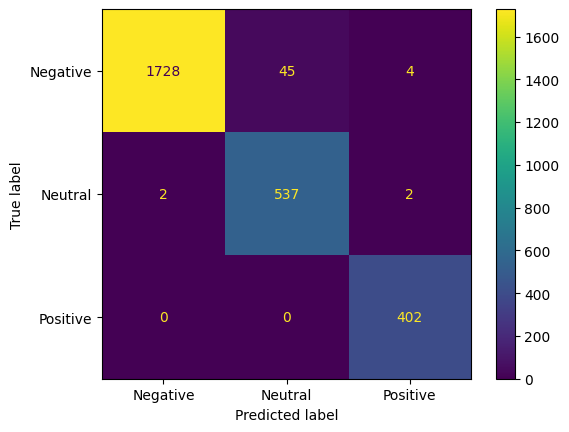

In [408]:
cm = confusion_matrix(y_test.argmax(1),y_pred.argmax(1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
plt.show()

### Show classification report

In [409]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       1.00      0.97      0.99      1777
     Neutral       0.92      0.99      0.96       541
    Positive       0.99      1.00      0.99       402

   micro avg       0.98      0.98      0.98      2720
   macro avg       0.97      0.99      0.98      2720
weighted avg       0.98      0.98      0.98      2720
 samples avg       0.98      0.98      0.98      2720



Overall, the results are pretty good, with a handful of negative tweets being predicted as neutral. I honestly did not expect the results to be as good as it is. I think that converting the emojis into text instead of removing them was a good choice, which helps the model to differentiate neutral tweets from positive or negative ones. If i had more time, I would probably try out different epochs and batch_size in the model fitting step and choose the best one. Training this model already took me around 10 hours, which means that I could only run this code once or twice if not I would have had nothing to show for it, really wish I had more computing resources. Another thing I could do better in was exploring different models. This is the base-RoBERTa model which means that there could have been more models out there on HuggingFace that has already been pre-trained on airline tweets.